In [1]:
import os
import sys

import json
import pickle

import scipy
import seaborn as sns

import numpy as np
import pandas as pd
from dtw import dtw
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import dcor

In [2]:
data = pd.read_csv("../data/data.csv")
data.rename(columns = {0:'Date'}, inplace = False)
cols = data.columns.tolist()
cols = cols[-1:]+cols[1:-1]
data  = data[cols]
data["Date"] = pd.to_datetime(data["Date"])
data = data.set_index("Date")
data.index = data.index - pd.Timedelta(days = 1)

meta = pd.read_csv("../data/meta.csv")

In [3]:
number_of_nans = data.isna().sum()
usable = number_of_nans[number_of_nans < 1000].index
data_nans_removed = data[usable].interpolate()
data_nans_removed

,1515,1516,1518,1521,1719,1722,1723,2040,2046,2048,...,1527,1729,1726,2541,1530,1734,2741,2545,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
1950-12-31,-114.0,-8.0,-88.0,130.0,238.5,204.5,194.5,305.0,408,376.0,...,-14,125.5,125.0,120.0,50.0,73.0,217.0,18.0,438.0,414.0
1951-01-01,-122.0,-22.0,-102.0,110.0,200.5,182.5,160.5,260.0,376,330.0,...,-16,117.5,125.0,86.0,28.0,81.0,146.0,20.0,417.0,400.0
1951-01-02,-129.0,-32.0,-119.0,80.0,164.5,164.5,114.5,220.0,334,291.0,...,-18,116.5,121.0,50.0,30.0,73.0,108.0,16.0,390.0,388.0
1951-01-03,-134.0,-36.0,-124.0,60.0,132.5,128.5,88.5,182.0,286,242.0,...,-20,108.5,121.0,24.0,25.0,67.0,82.0,16.0,360.0,370.0
1951-01-04,-153.0,-52.0,-135.0,50.0,110.5,108.5,80.5,147.0,239,195.0,...,-22,106.5,119.0,0.0,32.0,63.0,60.0,6.0,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-27.0,75.0,-69.0,309.0,478.0,138.0,204.0,451.0,-78,-153.0,...,148,46.0,54.0,48.0,155.0,52.0,74.0,-18.0,272.0,325.0
2020-12-27,-94.0,21.0,-50.0,333.0,488.0,206.0,252.0,464.0,20,-101.0,...,162,45.0,52.0,128.0,154.0,42.0,82.0,-17.0,272.0,325.0
2020-12-28,-137.0,-20.0,-92.0,311.0,481.0,201.0,250.0,461.0,120,-2.0,...,154,46.0,63.0,116.0,145.0,40.0,83.0,-22.0,272.0,325.0


In [4]:
def pearson(dx, dy):
    return scipy.stats.pearsonr(dx,dy)

def spearman(dx,dy):
    return scipy.stats.spearmanr(dx,dy)

def distance_correlation(dx,dy):
    return dcor.distance_correlation(dx, dy),0

def timewarping(dx,dy):
    distance, cost_matrix, acc_cost, path = dtw(np.array(dx).reshape(-1,1),np.array(dy).reshape(-1,1), dist = scipy.spatial.distance.euclidean)
    return distance



def corr(df,starting_point,interval,method,l,pv,p1):
    period2 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]

    for col in df.columns.tolist():
        cor, p_value = method(p1['2275'],period2[col])
        l.append(cor)
        pv.append(p_value)



def calculate_correlations(df,starting_point,interval,method):

    day = pd.Timedelta(1,'d')
    sp = starting_point
    l = []
    pv = []

    period1 = df[(df.index >= starting_point - interval) & (df.index <= starting_point + interval)]
    for i in np.linspace(0,5,5):
        starting_point = starting_point + day
        corr(df,starting_point,interval,method,l,pv,period1)
    starting_point =  sp + day
    for i in np.linspace(0,50,50):
        starting_point = starting_point - day
        corr(df,starting_point,interval,method,l,pv,period1)

    cm = np.transpose(np.reshape(np.array(l), (-1, len(df.columns))))
    pv = np.transpose(np.reshape(np.array(pv), (-1, len(df.columns))))

    return cm, pv


correlation_matrix, p_values = calculate_correlations(data_nans_removed,pd.Timestamp('2006-01-01'),pd.Timedelta(52,'w'),distance_correlation)

cr = pd.DataFrame(data = np.transpose(correlation_matrix), columns=data_nans_removed.columns)
cr.idxmax() - 5

/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


1515      4
1516      4
1518      3
1521      3
1719      5
1722      2
1723      2
2040      1
2046      1
2048      0
2271      0
2272      0
2274      0
2275      0
2278      2
2543      2
2753      5
2756      4
1514      4
1523      5
2736      7
1721      3
1724      3
1725      3
1520      3
1527      4
1729      4
1726      5
2541      2
1530      6
1734      4
2741      4
2545      4
210888    0
210900    0
dtype: int64

In [5]:
max_corr = pd.Series((cr.idxmax() - 5),name="maximum_correlation")
max_corr.index = max_corr.index.astype(int)

In [6]:
meta = pd.read_csv("../data/meta.csv")
meta = meta.set_index("reg_number")

meta_nans_removed = meta.loc[list(map(int,cr.columns.tolist()))]
meta_nans_removed = pd.concat([meta_nans_removed, max_corr], axis=1)


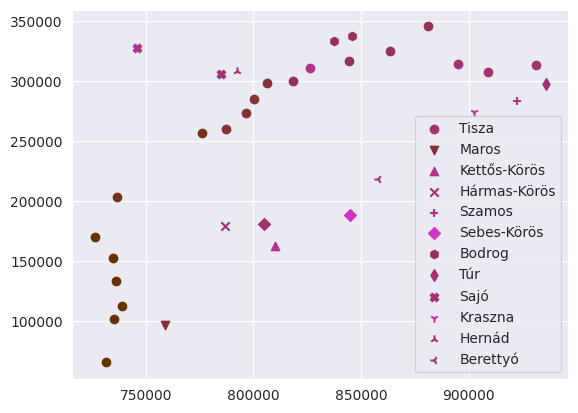

In [7]:
marker_dict = {
    'Tisza': 'o',
    'Maros': 'v',
    'Kettős-Körös': '^',
    'Hármas-Körös': 'x',
    'Szamos': '+',
    'Sebes-Körös' : 'D',
    'Bodrog' : 'h',
    'Túr' : 'd',
    'Sajó' : 'X',
    'Kraszna' : '1',
    'Hernád' : '2',
    'Berettyó': '3'}

def rgb(val):
    return [[0.4 + val * 0.06,0.2, 0.00 + abs(val * 0.11)]]

rivers = []
actors = []

for index,row in meta_nans_removed.iterrows():
    a = plt.scatter(row['EOVx'],row['EOVy'],c=rgb(row['maximum_correlation']),marker=marker_dict[row['river']])
    if row['river'] not in rivers:
        rivers.append(row['river'])
        actors.append(a)
plt.legend(actors,meta_nans_removed.river.unique())
plt.show()

In [36]:
data_nans_removed

,1515,1516,1518,1521,1719,1722,1723,2040,2046,2048,...,1527,1729,1726,2541,1530,1734,2741,2545,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
1950-12-31,-114.0,-8.0,-88.0,130.0,238.5,204.5,194.5,305.0,408,376.0,...,-14,125.5,125.0,120.0,50.0,73.0,217.0,18.0,438.0,414.0
1951-01-01,-122.0,-22.0,-102.0,110.0,200.5,182.5,160.5,260.0,376,330.0,...,-16,117.5,125.0,86.0,28.0,81.0,146.0,20.0,417.0,400.0
1951-01-02,-129.0,-32.0,-119.0,80.0,164.5,164.5,114.5,220.0,334,291.0,...,-18,116.5,121.0,50.0,30.0,73.0,108.0,16.0,390.0,388.0
1951-01-03,-134.0,-36.0,-124.0,60.0,132.5,128.5,88.5,182.0,286,242.0,...,-20,108.5,121.0,24.0,25.0,67.0,82.0,16.0,360.0,370.0
1951-01-04,-153.0,-52.0,-135.0,50.0,110.5,108.5,80.5,147.0,239,195.0,...,-22,106.5,119.0,0.0,32.0,63.0,60.0,6.0,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-27.0,75.0,-69.0,309.0,478.0,138.0,204.0,451.0,-78,-153.0,...,148,46.0,54.0,48.0,155.0,52.0,74.0,-18.0,272.0,325.0
2020-12-27,-94.0,21.0,-50.0,333.0,488.0,206.0,252.0,464.0,20,-101.0,...,162,45.0,52.0,128.0,154.0,42.0,82.0,-17.0,272.0,325.0
2020-12-28,-137.0,-20.0,-92.0,311.0,481.0,201.0,250.0,461.0,120,-2.0,...,154,46.0,63.0,116.0,145.0,40.0,83.0,-22.0,272.0,325.0


In [49]:
mask = (data_nans_removed.index> '2000-01-01') & (data_nans_removed.index <= '2001-01-01')

data_nans_removed[mask]

,1515,1516,1518,1521,1719,1722,1723,2040,2046,2048,...,1527,1729,1726,2541,1530,1734,2741,2545,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-02,-26.0,68.0,21.0,372.0,479.1,153.9,225.4,456.0,187,182.0,...,99,24.0,40.0,71.0,315.0,70.0,489.0,297.0,338.0,443.0
2000-01-03,-34.0,53.0,2.0,355.0,477.1,132.9,205.4,454.0,191,190.0,...,57,25.0,42.0,45.0,307.0,76.0,466.0,278.0,342.0,444.0
2000-01-04,-41.0,41.0,-13.0,345.0,478.1,122.9,199.4,448.0,174,186.0,...,41,24.0,47.0,28.0,294.0,77.0,431.0,265.0,339.0,439.0
2000-01-05,-38.0,39.0,-17.0,338.0,471.1,118.9,193.4,440.0,159,170.0,...,35,30.0,44.0,25.0,285.0,72.0,391.0,260.0,319.0,417.0
2000-01-06,-43.0,43.0,-17.0,337.0,474.1,110.9,191.4,442.0,144,151.0,...,29,32.0,43.0,15.0,273.0,58.0,341.0,249.0,303.0,403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-28,254.0,281.0,187.0,427.0,527.1,260.9,277.4,469.0,31,-145.0,...,41,63.0,91.0,157.0,110.0,32.0,-18.0,11.0,201.0,104.0
2000-12-29,399.0,371.0,274.0,469.0,544.1,340.9,339.4,499.0,242,33.0,...,164,81.0,69.0,255.0,113.0,39.0,-5.0,32.0,214.0,102.0
2000-12-30,460.0,514.0,400.0,562.0,580.1,406.9,399.4,525.0,367,165.0,...,213,86.0,121.0,333.0,112.0,44.0,-4.0,50.0,244.0,130.0


In [79]:

from statsmodels.tsa.stattools import grangercausalitytests
def causality_test(df, lag,l,pv):

    for col in df.columns.tolist():
        vals = grangercausalitytests(data_nans_removed[['2275',col]], maxlag = [lag],verbose = 0)
        l.append(vals[lag][0]['ssr_ftest'][0])
        pv.append(vals[lag][0]['ssr_ftest'][1])


causalities = []
p_values = []
for i in np.linspace(1,10,10):
    causality_test(data_nans_removed,i,causalities,p_values)

causalitiy_matrix = np.transpose(np.reshape(np.array(causalities), (-1, len(data_nans_removed.columns))))


/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/franzs/Schreibtisch/ecmi-hydrological-forecasting/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1

In [51]:
normalized_df=(data_nans_removed-data_nans_removed.min())/(data_nans_removed.max()-data_nans_removed.min())

In [58]:
data

,1515,1516,1518,1521,1719,1720,1722,1723,2040,2046,...,2751,2545,2740,210896,744612,744616,744618,744624,210888,210900
Date,,,,,,,,,,,,,,,,,,,,,
1950-12-31,-114.0,-8.0,-88.0,130.0,238.5,NaN,204.5,194.5,305.0,408,...,NaN,18.0,NaN,362.0,NaN,NaN,NaN,NaN,438.0,414.0
1951-01-01,-122.0,-22.0,-102.0,110.0,200.5,NaN,182.5,160.5,260.0,376,...,NaN,20.0,NaN,349.0,NaN,NaN,NaN,NaN,417.0,400.0
1951-01-02,-129.0,-32.0,-119.0,80.0,164.5,NaN,164.5,114.5,220.0,334,...,NaN,16.0,NaN,328.0,NaN,NaN,NaN,NaN,390.0,388.0
1951-01-03,-134.0,-36.0,-124.0,60.0,132.5,NaN,128.5,88.5,182.0,286,...,NaN,16.0,NaN,302.0,NaN,NaN,NaN,NaN,360.0,370.0
1951-01-04,-153.0,-52.0,-135.0,50.0,110.5,NaN,108.5,80.5,147.0,239,...,NaN,6.0,NaN,270.0,NaN,NaN,NaN,NaN,322.0,349.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,-27.0,75.0,-69.0,309.0,478.0,460.0,138.0,204.0,451.0,-78,...,198.0,-18.0,85.0,NaN,NaN,NaN,NaN,31.0,NaN,NaN
2020-12-27,-94.0,21.0,-50.0,333.0,488.0,460.0,206.0,252.0,464.0,20,...,216.0,-17.0,85.0,NaN,NaN,NaN,NaN,19.0,NaN,NaN
2020-12-28,-137.0,-20.0,-92.0,311.0,481.0,459.0,201.0,250.0,461.0,120,...,215.0,-22.0,87.0,NaN,NaN,NaN,NaN,24.0,NaN,NaN


In [59]:
def consecutive_nans(row):
    max_consec = 0
    current_consec = 0

    for value in row:
        if pd.isna(value):
            current_consec += 1
            max_consec = max(max_consec, current_consec)
        else:
            current_consec = 0

    return max_consec


In [92]:
data[(data.index >= '1950') & (data.index <= '2000')].apply(consecutive_nans,0)[data_nans_removed.columns]

1515        0
1516        0
1518        0
1521      730
1719        0
1722        0
1723      366
2040        0
2046        0
2048        0
2271        1
2272        0
2274        0
2275        0
2278        0
2543        0
2753        0
2756        0
1514        0
1523       31
2736        0
1721        0
1724        0
1725        0
1520        0
1527        0
1729        0
1726        0
2541        0
1530        1
1734        0
2741        0
2545      335
210888      0
210900    214
dtype: int64

In [62]:
data_nans_removed.columns

Index(['1515', '1516', '1518', '1521', '1719', '1722', '1723', '2040', '2046',
       '2048', '2271', '2272', '2274', '2275', '2278', '2543', '2753', '2756',
       '1514', '1523', '2736', '1721', '1724', '1725', '1520', '1527', '1729',
       '1726', '2541', '1530', '1734', '2741', '2545', '210888', '210900'],
      dtype='object')